# PageRank is one of the reasons why google succeeded so early. It was the key mechanic behind their powerful search engine that allowed sites that were more popular to be displayed at the top, just simply using linear algebra.
It is a very simple algorithm that is definitely very powerful and can be used in many different ways.
This algorithm works by using linear algebra techniques to determine the likelihood of someone following a link to a page.


# Creating a Google Matrix
The implementation is as follows: \
We start with an input graph which we must normalize it into a stochastic matrix. \
This is done by setting the columns to sum to 1.
We can do this in numpy by just dividing each column by its sum.\

Next we will apply the page rank algorithm to the matrix.\
The page rank algorithm can be broken up into two parts.\
The first part is the random jump, and then the second part is the chance of link following.\
This follows the idea of the random surfer model. https://en.wikipedia.org/wiki/Random_surfing_model\
The algorithm is as follows: $$\frac{1-d}{n} + d \sum_{i=1}^{n} \frac{P_{ij}}{C_j}$$
Where d is the dampening factor, n is the number of rows, P is the transition matrix, and C is the column sum.
The first part, $\frac{1-d}{n}$, is the random jump, and the second part, $d\sum_{i=1}^{n} \frac{P_{ij}}{C_j}$, is the chance of link following. \
The dampening factor is most commonly 0.85, which means that 85% of the time the user will follow a link, and 15% of the time they will jump to a random page.


In [193]:
import numpy as np

def page_rank(input_graph, dampening=0.85):
    # First we get the number of nodes in each row.
    n = len(input_graph)
    # We will use P as our transition matrix as it's what the algorithm uses.
    P = input_graph
    # We convert it to float because by default numpy will use int64 which is not what we want.
    P = P.astype(float)

    # We sum up the columns and normalize them so that they sum to 1.
    for j in range(n):
        col_sum = np.sum(P[:, j])
        if col_sum != 0:
            P[:, j] /= col_sum

    # We apply the algorithm to the matrix and convert it to a Google matrix.
    P = dampening * P + (1 - dampening) * np.ones((n, n)) / n
    # P is now a stochastic matrix and we will solve for the steady state.
    # The steady state is the solution to the equation (P - I)r = 0 which shows us the most popular links.

    A = P - np.eye(n) # (P -I)r = 0
    # We set the last row to be all 1s and the last element of b to be 1. We do this because (P-I)r = 0 is homogeneous and we need to add a constraint to make it solvable.
    # We know we want a probability vector so we set the last row to be all 1s and the last element of b to be 1.
    # We know that $\sum_{i=1}^n r_i = 1$ so we can set the last element of b to be 1.
    # So we set the last row of A to be all 1s and the last element of b to be 1 to satisfy this equation.
    A[-1] = np.ones(n) # last row is 1
    b = np.zeros(n)
    b[-1] = 1 # last element is 1

    # We can now solve the equation A pi = b for pi and then return that.
    pi = np.linalg.solve(A, b)



    return pi

Now we can initialize our inputs with an array, and then label and sort the outputs.

In [194]:

input = np.array([
    [0, 1, 1 , 1, 0], # A
    [1, 0, 0, 1, 1], # B
    [1, 1, 0, 0, 1], # C
    [1, 1, 1, 0, 1], # D
    [1, 1, 0, 0, 0] # E
]
)
# second example input
input2 = np.array([
    [1, 0, 0 , 1, 1], # A
    [0, 1, 1, 1, 0], # B
    [0, 0, 0, 0, 1], # C
    [1, 1, 1, 0, 0], # D
    [1, 0, 1, 0, 0], # E
    ])

labels = ["A", "B", "C", "D", "E"]
output = page_rank(input)
output = {labels[i]: output[i].item() for i in range(len(labels))}
sorted_output = sorted(output.items(), key=lambda x: x[1], reverse=True)

print(sorted_output)
print("The most popular page is: ", labels[np.argmax(page_rank(input))])

output2 = page_rank(input2)
output2 = {labels[i]: output2[i].item() for i in range(len(labels))}
sorted_output = sorted(output2.items(), key=lambda x: x[1], reverse=True)

print(sorted_output)
print("The most popular page is: ", labels[np.argmax(page_rank(input2))])


[('A', 0.24790409508217684), ('D', 0.2366675653815044), ('B', 0.21993090087360642), ('C', 0.16608250202210842), ('E', 0.12941493664060397)]
The most popular page is:  A
[('B', 0.2758897851183104), ('A', 0.26427533129035274), ('D', 0.24615283905303656), ('E', 0.12889968037775454), ('C', 0.08478236416054569)]
The most popular page is:  B


Now, using a little AI and some python libraries we can visualize the graph to see what is most powerful and why.

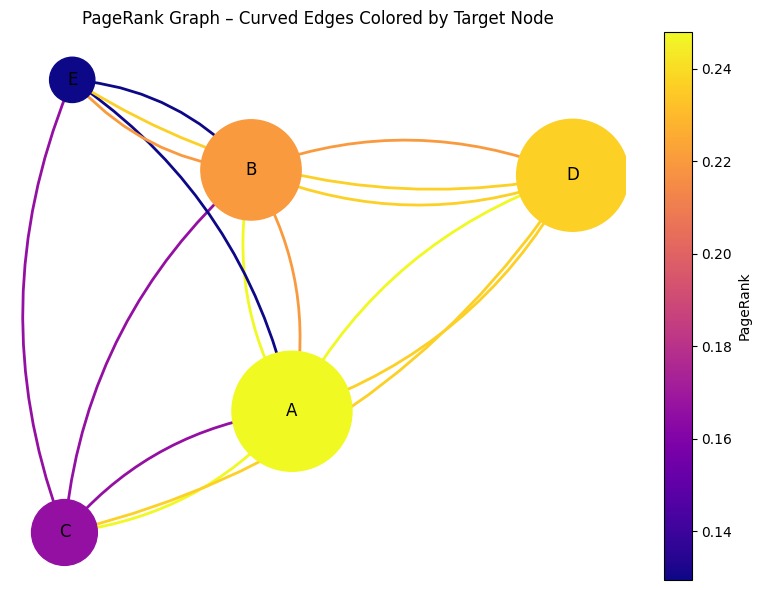

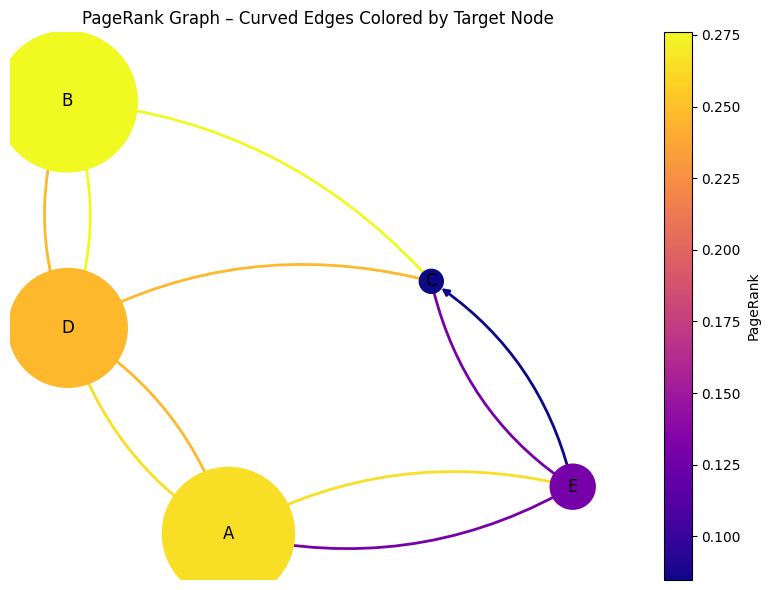

In [195]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import matplotlib.colors as mcolors
import matplotlib as mpl

def draw_graph(input, output, labels):
    G = nx.DiGraph()
    n = len(labels)
    for i in range(n):
        for j in range(n):
            if input[i][j] == 1:
                G.add_edge(labels[j], labels[i])  # j → i

    # PageRank-based node sizes and colors
    node_sizes = [output[node]**3 * 700**2 for node in G.nodes()]
    node_colors = [output[node] for node in G.nodes()]

    # Layout for consistent node placement
    pos = nx.spring_layout(G, seed=42)

    values = np.array(node_colors)
    norm = mcolors.Normalize(vmin=values.min(), vmax=values.max())
    cmap = mpl.colormaps.get_cmap('plasma')

    fig, ax = plt.subplots(figsize=(8, 6))

    edgelist = list(G.edges())  # get consistent edge order

    edge_colors = [cmap(norm(output[v])) for _, v in edgelist]



    # Draw nodes
    nx.draw_networkx_nodes(
        G, pos, ax=ax,
        node_size=node_sizes,
        node_color=node_colors,
        cmap='plasma'
    )

    # Draw labels
    nx.draw_networkx_labels(G, pos, ax=ax)

    # Draw edges with curves + color
    nx.draw_networkx_edges(
        G, pos,
        ax=ax,
        edgelist=edgelist,
        edge_color=edge_colors,
        width=2,
        connectionstyle='arc3,rad=0.2'  # <-- makes edges curve
    )

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # this is fine
    fig.colorbar(sm, ax=ax, label='PageRank')  # ✅ attach to the correct figure

    # Final tweaks
    ax.set_title("PageRank Graph – Curved Edges Colored by Target Node")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

draw_graph(input, output, labels)
draw_graph(input2, output2, labels)
